<table align="center">
   <td align="center"><a target="_blank" href="https://colab.research.google.com/github/umbcdata602/fall2020/blob/master/lab_lda_pca.ipynb">
<img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>

# Lab: Dimensionality reduction with LDA & PCA

Investigate and compare LDA and PCA for dimensionality reduction.

### References

* [Section 4.3.3 (p113) of *Elements of Statistical Learning*](https://web.stanford.edu/~hastie/ElemStatLearn/) -- stanford.edu
* [Raschka's ch05.ipynb](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch05/ch05.ipynb) -- github
* [Linear and Quadratic Discriminant Analysis](https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html) -- scikit-learn.org3 
* [Section 5.05 of VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html) -- github


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Convenience functions

These plotting functions come directly from the scikit-learn example.

In [2]:
# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='black', linewidth=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], 'blue')

# Generate data and perform LDA & QDA

This cell comes directly from the scikit-learn example with two minor changes:
* n_samples is easy to adjust
* aspect ratio set to "equal" in the plots

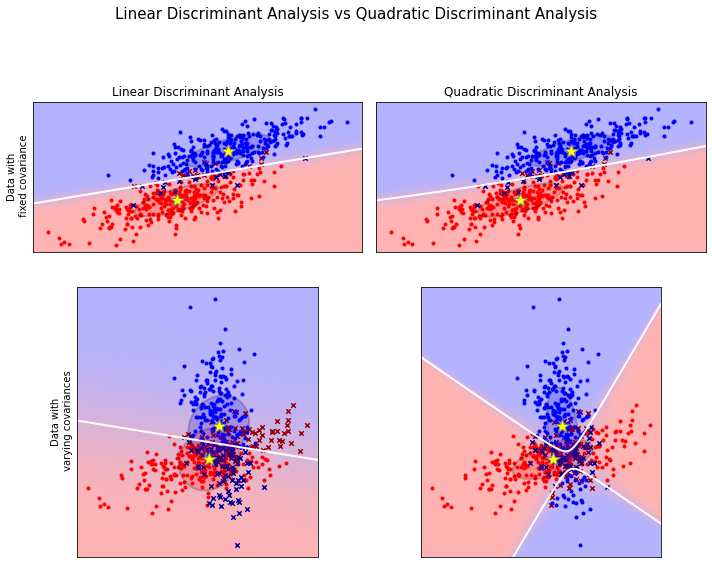

In [3]:
# #############################################################################
# Generate datasets

n_samples = 300 # initial value: 300

def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n = n_samples
    dim = 2  # Initial value 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n, np.int8), np.ones(n, np.int8)))
    return X, y


def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n = n_samples
    dim = 2  # Initial value 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n, np.int8), np.ones(n, np.int8)))
    return X, y


plt.figure(figsize=(10, 8), facecolor='white')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant Analysis',
             y=0.98, fontsize=15)

for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')
    plt.gca().set_aspect('equal')

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis('tight')
    plt.gca().set_aspect('equal')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Sample statistics

* NOTE: After running the code above, `X` and `y` contain data with "varying covariances".
* VanderPlas [Section 2.05: Computation on arrays and broadcasting](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.05-Computation-on-arrays-broadcasting.ipynb) -- github

In [4]:
print('X.shape:', X.shape)
print('y.shape:', y.shape)
print(np.unique(y))

X.shape: (600, 2)
y.shape: (600,)
[0 1]


In [5]:
# Compute the covariance with numpy
for k in np.unique(y):
    Xk = X[y == k, :]
    cov = np.cov(Xk.T)
    print('\nClass', k)
    print('Covariance:\n', cov)


Class 0
Covariance:
 [[24.84216259  6.92287991]
 [ 6.92287991  6.03005133]]

Class 1
Covariance:
 [[ 3.71288339 -2.66486199]
 [-2.66486199 23.93019635]]



Class 0
Covariance:
 [[24.75935538  6.89980364]
 [ 6.89980364  6.00995116]]

Class 1
Covariance:
 [[ 3.70050711 -2.65597912]
 [-2.65597912 23.85042903]]


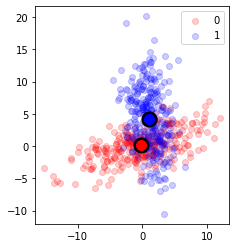

In [6]:
# Compute the mean (centroid) and covariance by hand (with broadcasting)
for k, color in zip(np.unique(y), ['red', 'blue']):
  Xk = X[y == k, :]
  mu = np.mean(Xk, axis=0)
  Xp = Xk - mu
  cov = np.dot(Xp.T, Xp) / len(Xp)
  print('\nClass', k)
  print('Covariance:\n', cov)
  plt.scatter(Xk[:,0], Xk[:,1], c=color, alpha=.2, label=k)
  plt.plot(mu[0], mu[1], 'ok', markersize=15)
  plt.plot(mu[0], mu[1], 'o', c = color, markersize=10)
plt.gca().set_aspect('equal')
plt.legend();

# PCA

Compare this section with cells 7-13 of Raschka's ch05.ipynb.

[[14.61425056  3.36307033]
 [ 3.36307033 19.2031711 ]]

Eigenvalues (before): [12.83749603 20.97992563]
Eigenvalues (after): [20.97992563 12.83749603]
COV for class 0: [[24.84216259  6.92287991]
 [ 6.92287991  6.03005133]]
COV for class 1: [[ 3.71288339 -2.66486199]
 [-2.66486199 23.93019635]]


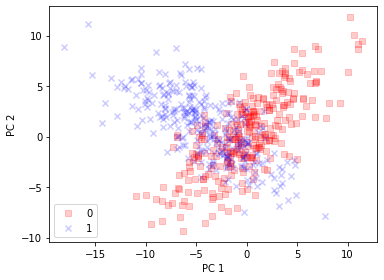

In [7]:
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print(cov_mat)

# Make sure eigenvalues (and associated eigenvectors) are decreasing order
print('\nEigenvalues (before):', eigen_vals)
w = eigen_vecs
if eigen_vals[1] > eigen_vals[0]:
  eigen_vals = eigen_vals[[1,0]]
  w = eigen_vecs[:,[1,0]]
print('Eigenvalues (after):', eigen_vals)

X_pca = X.dot(w)
markers = ['s', 'x']

for k, c, m in zip(np.unique(y), ['red', 'blue'], markers):
    cov = np.cov(X[y==k,:].T)
    print('COV for class {}:'.format(k), cov)
    plt.scatter(X_pca[y == k, 0], 
                X_pca[y == k, 1], 
                c=c, label=k, marker=m, alpha=.2)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout();
plt.gca().set_aspect('equal')


Eigenvalues: [12.83749603 20.97992563]

Eigen-pairs:
 [(20.979925629566655, array([-0.46712887, -0.88418924])), (12.837496031340649, array([-0.88418924,  0.46712887]))]

Eigenvector matrix:
 [[-0.46712887 -0.88418924]
 [-0.88418924  0.46712887]]

Identity:
 [[ 1.00000000e+00 -1.27018384e-17]
 [-1.27018384e-17  1.00000000e+00]]


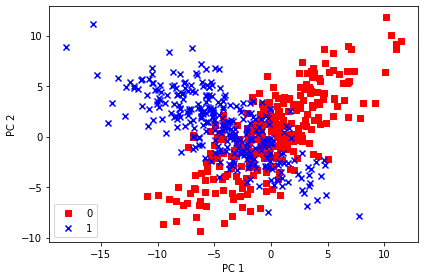

In [8]:
# This uses the relatively general (3-class) code from Raschka
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues:', eigen_vals)

# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
print("\nEigen-pairs:\n", eigen_pairs)

# Create a matrix with eigenvectors as columns
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('\nEigenvector matrix:\n', w)

# Confirm orthogonality
print("\nIdentity:\n", w.dot(w))

X_pca = X.dot(w)
markers = ['s', 'x']

for i, c, m in zip(np.unique(y), ['red', 'blue'], markers):
    plt.scatter(X_pca[y == i, 0], 
                X_pca[y == i, 1], 
                c=c, label=i, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout();

[0.4777858 2.1960808]
[[-0.88418924 -0.46712887]
 [ 0.46712887 -0.88418924]]
[0 1]
0.47778579579653446
-0.8841892431851442
[0 1]
0.47778579579653446
-0.46712887112196544


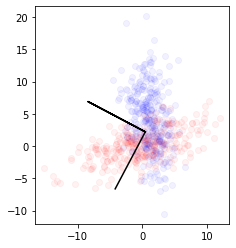

In [9]:
# Compute the mean (centroid) and covariance by hand (with broadcasting)
fig, axes = plt.subplots()
axes.set_aspect(1)

# Plot the data
mu = np.mean(X, axis=0)
print(mu)
print(eigen_vecs)
for k, color in zip(np.unique(y), ['red', 'blue']):
  Xk = X[y == k, :]
  plt.scatter(Xk[:,0], Xk[:,1], c=color, alpha=.05)

# Plot the eigenvectors (there are 2)
for k in range(2):
  print(np.unique(y))
  print(mu[0])
  print(eigen_vecs[0,k])
  xs = (2 - k) * [mu[0], mu[0] + 10*eigen_vecs[0, k]]
  ys = (2 - k) * [mu[1], mu[1] + 10*eigen_vecs[1, k]]
  plt.plot(xs, ys, 'k')

# LDA

(600, 1)
{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': True, 'tol': 0.0001}


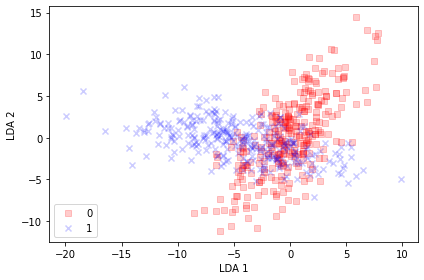

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(store_covariance=True)
X_lda = lda.fit_transform(X, y)

print(X_lda.shape)

# Parameters used to call LDA
print(lda.get_params())

# Extract coefficient vector
coef = lda.coef_
assert coef.shape == (1,2)

# Reversing sign so result is closer to PCA
coef = - coef

# Normailze (so it plots nicely)
coef = coef / (np.dot(coef[0], coef[0]))**(1/2)

coef2 = np.array([coef[0,1], - coef[0, 0]])

a = X.dot(coef.T)
b = X.dot(coef2.T)

for i, c, m in zip(np.unique(y), ['red', 'blue'], markers):
    plt.scatter(a[y == i], 
                b[y == i], 
                c=c, label=i, marker=m, alpha=.2)
    
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.legend(loc='lower left')
plt.tight_layout();

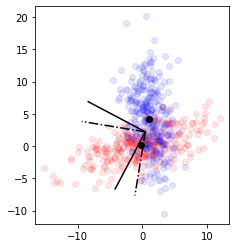

In [11]:
# Compute the mean (centroid) and covariance by hand (with broadcasting)
fig, axes = plt.subplots()
axes.set_aspect(1)

mu = np.mean(X, axis=0)
for k, color in zip(np.unique(y), ['red', 'blue']):
  Xk = X[y == k, :]
  muk = np.mean(Xk, axis=0)
  Xp = Xk - muk
  plt.scatter(Xk[:,0], Xk[:,1], c=color, alpha=.1)
  plt.plot(muk[0], muk[1], 'ok')

  # Plot the eigenvectors (there are 2)
  scl = 10
  plt.plot([mu[0], mu[0] + scl*eigen_vecs[0, k]], [mu[1], mu[1] + scl*eigen_vecs[1, k]], 'k')

# Plot the LDA axis (and its orthogonal component)
scl = 10
plt.plot([mu[0], mu[0] + scl*coef[0][0]], [mu[1], mu[1] + scl*coef[0][1]], '-.k')
plt.plot([mu[0], mu[0] + scl*coef2[0]], [mu[1], mu[1] + scl*coef2[1]], '-.k');